In [1]:
import numpy
import matplotlib.pyplot as plt
import texplot

In [2]:
data_ntk = numpy.load('plot_data_cifar_ntk.npy', allow_pickle=True).item()

# Flodance

In [7]:
from detkit import FitLogdet


# ===
# fit
# ===

def fit(log_eigs, num_model_param=1, fit_interval=None, m=0, n=0, alpha=0.0,
        scale_x=1, scale_y=1, lam=0, smooth_interval=None, verbose=False):
    """
    FLODANCE.
    
    num_model_param: number of model parameters.
    m: num Laurent series terms with logarithm.
    n: num Laurent series terms without logarithm.
    lam: regularization parameter lambda.
    """

    # Adjust ntk scale
    scale = numpy.sqrt(num_model_param)
    log_eigs_ = log_eigs + numpy.log(scale)

    # x and y
    num_class = 10
    y = numpy.cumsum(log_eigs_)
    y = y[(num_class-1)::num_class]
    x = numpy.arange(1, y.size+1)

    # Intervals
    fit_interval = numpy.array(fit_interval)
    extrap_interval = numpy.array([fit_interval[1], x.size])

    # Masks
    mask_fit = (x >= fit_interval[0]) & (x <= fit_interval[1])
    mask_extrap = (x >= extrap_interval[0]) & (x <= extrap_interval[1])

    # Fit
    fl = FitLogdet(m=m, n=n, alpha=alpha, scale_x=scale_x, scale_y=scale_y)
    # sd.fit(x[mask_fit], y[mask_fit], verbose=True)
    fl.fit(x[mask_fit], y[mask_fit], lam=lam, smooth_interval=smooth_interval, verbose=verbose)

    if verbose:
        print('\nParameters:')
        print(fl.param)
        print('')

    # Fit and extrapolate
    y_fit = fl.eval(x[mask_fit])
    y_extrap = fl.eval(x[mask_extrap])

    # Output
    results = {
        'x': x,
        'y': y,
        'mask_fit': mask_fit,
        'y_fit': y_fit,
        'fit_interval': fit_interval,
        'mask_extrap': mask_extrap,
        'y_extrap': y_extrap,
        'extrap_interval': extrap_interval,
    }
    
    return results

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import FancyBboxPatch


# ======
# relerr
# =====

def relerr(y1, y2):
    """
    Relative error
    """
    
    return abs(y1 - y2) / abs(y2)


# =====
# SAMPE
# =====

def sampe(y1, y2):
    """
    Symmetric Mean Absolute Error Percentage.
    """
    
    return 2.0 * numpy.abs(y1 - y2) / (numpy.abs(y1) + numpy.abs(y2))


# =========
# Plot axis
# =========

def plot_axis(fig, ax, results, options):
    """
    Plot each axis of the figure.
    """
    
    # Extract results
    x = results['x']
    y = results['y']
    mask_fit = results['mask_fit']
    y_fit = results['y_fit']
    fit_interval = results['fit_interval']
    mask_extrap = results['mask_extrap']
    y_extrap = results['y_extrap']
    extrap_interval = results['extrap_interval']
    
    # Extract options
    y_error_lim = options['y_error_lim']
    decimals = options['decimals']
    title = options['title']
    box_x_shift = options['box_x_shift']
    legend_x_shift = options['legend_x_shift']
    ylim = options['ylim']
    asym = options['asym']
    fit_only = options['fit_only']
    abs_error = options['abs_error']
    
    # -----------------------
    # Left Ordinate (Logdets)
    # -----------------------

    # Plot curves
    ax.plot(x, y, color='black', label='Empirical')
    
    # Asymptote line, despite x*log(x) does not asymptote to any c*x)
    if asym:
        asym_mask = numpy.arange(int(x.size * 0.99), x.size)
        x_asym = x[asym_mask]
        y_asym = y[asym_mask]
        coeff = numpy.polyfit(x_asym, y_asym, deg=1)
        y_asym_fit = coeff[0] * x + coeff[1]
        ax.plot(x, y_asym_fit, '--', color='gray', label='Asymptote', zorder=-1)
        print(f'asymptote slope: {coeff[0]}')

    # Fit and extrapolation plots
    if fit_only:
        ax.plot(x[mask_fit], y_fit, color='darkorange', linewidth=1.5, zorder=2, label='Fit')
    else:
        ax.plot(x[mask_fit], y_fit, color='darkorange', linewidth=1.5, zorder=2, label='Fit')
        ax.plot(x[mask_extrap], y_extrap, color='maroon', label='Extrapolation')

    # Axis limits
    diff = numpy.max(y) - numpy.min(y)
    #ax.set_ylim([numpy.min(y) - diff * 0.02, numpy.max(y) + diff *  0.02])
    ax.set_xlim([0, x[-1]])

    # Tick formatters
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    # ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)

    # Axis labels
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(r'$\ell_n$')

    # Legend
    leg1 = ax.legend(fontsize='x-small', title=r'\emph{Left Ordinate}', title_fontsize='x-small',
                     loc='upper left', frameon=False, bbox_to_anchor=(legend_x_shift, 0.987),
                     alignment='left')

    # -----------------------
    # Right Ordinate (errors)
    # -----------------------

    ax2 = ax.twinx()

    # Plot curves
    if abs_error:
        y_error_fit = numpy.abs(y_fit - y[mask_fit])
        y_error_extrap = numpy.abs(y_extrap, y[mask_extrap])
        ax2_ylabel = 'Absolute Error'
    else:
        y_error_fit = 100.0 * sampe(y_fit, y[mask_fit])
        y_error_extrap = 100.0 * sampe(y_extrap, y[mask_extrap])
        ax2_ylabel = 'Relative Error'
    
    if fit_only:
        ax2.plot(x[mask_fit], y_error_fit, color='powderblue',
                 label=ax2_ylabel, zorder=-2)
    else:
        ax2.plot(x[mask_extrap], y_error_extrap, color='powderblue',
                 label=ax2_ylabel, zorder=-2)
        
        print(f'Relative Error: {y_error_extrap[-1]}')
    
    # Axis limits
    # ax2.set_ylim([0, 2])
    # ax2.set_yticks(numpy.arange(0, y_error_lim, 2))
    ax2.set_ylim(bottom=0)
    if y_error_lim is not None:
        ax2.set_ylim(top=y_error_lim)

    # Axis labels
    if abs_error:
        ax2.set_ylabel(r'$\vert \hat{\ell}_n - \ell_n \vert$')
    else:
        ax2.set_ylabel(r'$\vert 1 - \hat{\ell}_n / \ell_n \vert$')

    # Axis formatters
    if abs_error:
        formatter2 = ScalarFormatter(useMathText=True)
        formatter2.set_scientific(True)
        formatter2.set_powerlimits((-1, 1))
        ax2.yaxis.set_major_formatter(formatter2)
    else:
        ax2.yaxis.set_major_formatter(PercentFormatter(decimals=decimals))

    # Legend
    leg2_y = 0.72
    if not fit_only: leg2_y -= 0.03
    if asym: leg2_y -= 0.03
    leg2 = ax2.legend(fontsize='x-small', title=r'\emph{Right Ordinate}', title_fontsize='x-small',
                      loc='upper left', frameon=False, bbox_to_anchor=(legend_x_shift, leg2_y),
                      alignment='left')

    # Bring ax2 behind ax
    ax.set_zorder(1)
    ax2.set_zorder(0)
    ax.set_facecolor('none')

    # Draw this after all above (gray fill for fit interval)
    if ylim is not None:
        ax.set_ylim(ylim)
    y1 = ax.get_ylim()[0]
    y2 = ax.get_ylim()[1]
    if not fit_only:
        ax.fill_between(fit_interval, y1=y1, y2=y2, color='gray',
                        alpha=0.2, zorder=0)

    #ax.set_xscale('log')

    ax.set_title(title)
    
    # Unify both legends in one box
    bbox1 = leg1.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
    bbox2 = leg2.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())

    dx = box_x_shift
    dy = 0.02
    x0 = min(bbox1.x0, bbox2.x0) + dx
    y0 = min(bbox1.y0, bbox2.y0) + dy
    x1 = max(bbox1.x1, bbox2.x1) + dx
    y1 = max(bbox1.y1, bbox2.y1) + dy

    frame = FancyBboxPatch((x0, y0), x1 - x0, y1 - y0,
                           transform=fig.transFigure, edgecolor="silver",
                           facecolor=(1, 1, 1, 0.4), alpha=0.9, linewidth=0.8, zorder=-1,
                           boxstyle="round,pad=0.005,rounding_size=0.008")
    fig.patches.append(frame)

{'rank': np.int64(9),
 'residuals': np.float64(0.024623431004335075),
 'singular_values': array([2.09693005e+03, 5.43564023e+01, 1.87382215e+00, 2.08480537e-01,
       7.88125586e-03, 5.49124605e-04, 3.54118138e-05, 1.32331029e-06,
       8.38549356e-08])}

Parameters:
[ 8.40917450e+00  1.52972931e+01 -8.61008433e+03  2.25631655e+03
  1.04370153e+05  6.88144474e+05 -2.06642826e+05 -5.25561010e+04
  4.64044759e+05]

asymptote slope: 130.68319281599332
Relative Error: 4.511279017708004
Plot saved to "/home/sia/work/scripts/free_decompression/ntk/./plot-tmp/scale_law_pred.pdf".


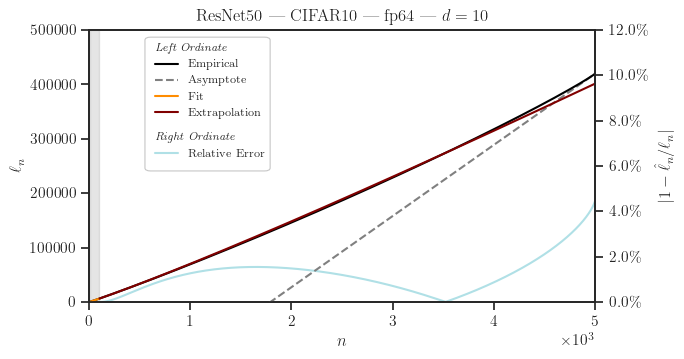

In [10]:
# ========
# Fit data
# ========

results = fit(
        data_ntk['eigs'][-1],
        num_model_param=1, #23574015,
        fit_interval=[100//10, 2**10//10],
        # m=11,
        m=3, n=3,
        # m=0,
        # n=5,
        alpha=0.0,
        scale_x=1, scale_y=1,
        # lam=5e6,
        lam=0, #5e3,
        smooth_interval=[2**10//10, 5e3],
        verbose=True)

# =============
# Plot Settings
# =============

# For Latex
rc = {
    'text.latex.preamble': r'\usepackage{amsmath} ' +
                           r'\usepackage{amssymb} ' +
                           r'\usepackage{xcolor}'
}

# For resnet9 axis
options = {
    'title': r'ResNet50 | CIFAR10 | fp64 | $d=10$',
    'ylim': [0, 5e5],           # lower and upper limits of the left ordinate
    'y_error_lim': 12,             # upper limit of right ordinate
    'decimals': 1,                # num decimals for percentages on the right ordinate
    'legend_x_shift': 0.11,       # horizontal shift for the content of legends
    'box_x_shift': 0.005,       # horizontal shift for the box around legends
    'asym': True,                 # Plot asymptote like (experimental)
    'fit_only': False,            # Only plots the fitting region (no extrapolation)
    'abs_error': False,           # If True, plots absolute error, otherwise relative error.
}

# ====
# Plot
# ====

import texplot

with texplot.theme(rc=rc, use_latex=True):

    fig, ax = plt.subplots(ncols=1, figsize=(7, 3.75))

    plot_axis(fig, ax, results, options)

    plt.tight_layout()

    save_filename = './plot-tmp/scale_law_pred.pdf'
    texplot.show_or_save_plot(plt, default_filename=save_filename,
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

In [57]:
eigs = data_ntk['eigs']
subsizes = numpy.array(data_ntk['subsizes'])
num_class = 10

lds_flodance = numpy.zeros((len(eigs),), dtype=float)
lds_flodance_exact = numpy.zeros((len(eigs),), dtype=float)

for i in range(len(eigs)):

    results = fit(
            eigs[i],
            num_model_param=1, #23574015,
            fit_interval=[100//10, 2**10//10],
            m=3, n=3,
            alpha=0.0,
            scale_x=1, scale_y=1,
            lam=0,
            smooth_interval=[2**10//10, 5e3],
            verbose=True)

    # Extract results
    x = results['x']
    y = results['y']
    mask_fit = results['mask_fit']
    y_fit = results['y_fit']
    fit_interval = results['fit_interval']
    mask_extrap = results['mask_extrap']
    y_extrap = results['y_extrap']
    extrap_interval = results['extrap_interval']
    
    # xx = x[mask_extrap]
    # yy = y[mask_extrap]
    
    # idx = numpy.searchsorted(xx, subsizes // num_class)
    
    # xx_2 = xx[idx]
    # yy_2 = yy[idx]
    # y_extrap_2 = y_extrap[idx]
    # y_extrap_error_2 = 100.0 * sampe(y_extrap_2, yy_2)

    lds_flodance[i] = y_extrap[-1]
    lds_flodance_exact[i] = y[-1]

{'rank': np.int64(9),
 'residuals': np.float64(0.9833174136805913),
 'singular_values': array([2.09693005e+03, 5.43564023e+01, 1.87382215e+00, 2.08480537e-01,
       7.88125586e-03, 5.49124605e-04, 3.54118138e-05, 1.32331029e-06,
       8.38549356e-08])}

Parameters:
[ 1.30086211e+02 -7.29330771e+02 -1.64381861e+05  4.44249301e+04
  1.88268972e+06  1.16515370e+07 -3.58780538e+06 -5.65819314e+05
  7.50089581e+06]

{'rank': np.int64(9),
 'residuals': np.float64(0.001042860084136281),
 'singular_values': array([2.09693005e+03, 5.43564023e+01, 1.87382215e+00, 2.08480537e-01,
       7.88125586e-03, 5.49124605e-04, 3.54118138e-05, 1.32331029e-06,
       8.38549356e-08])}

Parameters:
[ 1.38424071e+01  3.33632501e+00 -1.03308501e+04  3.02660914e+03
  1.01933314e+05  5.42460714e+05 -1.77246104e+05  1.64044159e+04
  2.85492143e+05]

{'rank': np.int64(9),
 'residuals': np.float64(0.0010424981696353969),
 'singular_values': array([2.09693005e+03, 5.43564023e+01, 1.87382215e+00, 2.08480537e-01,
  

In [58]:
# Extract experiment results
eigs = data_ntk['eigs']
subsizes = data_ntk['subsizes']
pdfs = data_ntk['pdfs']
pdfs_pred = data_ntk['pdfs_pred']
x_pred = data_ntk['x_pred']

# Scale to adjust the matrix
# num_model_param=23574015
# scale = numpy.sqrt(num_model_param)
# log_scale = numpy.log(scale)
log_scale = 0

# Exact solution and the prediction from free decompression
lds_exact = numpy.zeros((len(subsizes),), dtype=float)
lds_free = numpy.zeros((len(subsizes),), dtype=float)

for i in range(len(subsizes)):
    
    lds_exact[i] = numpy.sum(eigs[i] + log_scale)

    mass = numpy.trapz(pdfs_pred[i], x_pred)
    mu_1 = np.trapz(x_pred * pdfs_pred[i] / mass, x_pred) + log_scale
    lds_free[i] = mu_1 * subsizes[i]

# Relative errors
err_free = relerr(lds_free, lds_exact)
err_flodance = relerr(lds_flodance, lds_flodance_exact)

Plot saved to "/home/sia/Dropbox/test/free/compare_freealg_flodance.pdf".


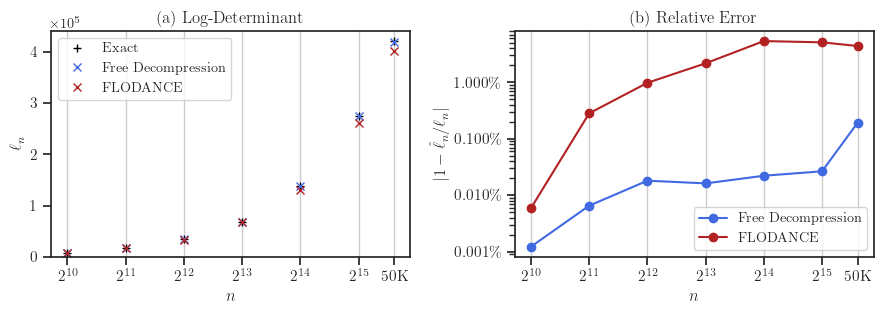

In [66]:
from matplotlib.ticker import PercentFormatter, ScalarFormatter
import matplotlib.ticker as mticker


def _smart_label(val, _pos=None):
    """Return '$2^{k}$' if val is an exact power of two, else a nice decimal."""
    k = np.log2(val)
    if np.isclose(k, int(k)):
        return rf'$2^{{{int(k):d}}}$'
    if val >= 1000:
        return f'{val//1000:0.0f}K'.rstrip('0').rstrip('.')
    return str(val)

with texplot.theme(use_latex=True):
    
    fig, ax = plt.subplots(figsize=(9, 3.3), ncols=2)

    start = 0
    ticks = subsizes[start:]
    ax[0].plot(subsizes[start:], lds_exact[start:], '+', color='black', label='Exact')
    ax[0].plot(subsizes[start:], lds_free[start:], 'x', color='royalblue', label='Free Decompression')
    ax[0].plot(subsizes[start:], lds_flodance[start:], 'x', color='firebrick', label='FLODANCE')
    ax[0].grid(axis='x')
    ax[0].set_xscale('log', base=2)
    # ax[0].set_yscale('log')
    ax[0].set_ylim(bottom=0)
    ax[0].legend(fontsize='small')
    ax[0].set_xlabel(r'$n$')
    ax[0].set_ylabel(r'$\ell_n$')
    ax[0].set_title(r'(a) Log-Determinant')
    ax[0].xaxis.set_major_locator(mticker.FixedLocator(ticks))
    ax[0].xaxis.set_major_formatter(mticker.FuncFormatter(_smart_label))
    ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax[0].ticklabel_format(axis='y', style='scientific', scilimits=(5,5))
    ax[0].yaxis.get_offset_text().set_fontsize('small')

    start = 0
    ticks = subsizes[start:]
    ax[1].plot(subsizes[start:], err_free[start:], '-o', color='royalblue', label='Free Decompression')
    ax[1].plot(subsizes[start:], err_flodance[start:], '-o', color='firebrick', label='FLODANCE')
    ax[1].grid(axis='x')
    ax[1].set_xscale('log', base=2)
    ax[1].set_yscale('log')
    ax[1].legend(fontsize='small')
    ax[1].set_xlabel(r'$n$')
    ax[1].set_ylabel(r'$\vert 1 - \hat{\ell}_n / \ell_n \vert$')
    ax[1].set_title('(b) Relative Error')
    # ax[1].set_ylim(top=0.1)
    ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=3))
    ax[1].xaxis.set_major_locator(mticker.FixedLocator(ticks))
    ax[1].xaxis.set_major_formatter(mticker.FuncFormatter(_smart_label))
    
    plt.tight_layout()
    save_filename = './plot-tmp/compare_freealg_flodance.pdf'
    texplot.show_or_save_plot(plt, default_filename=save_filename,
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

In [65]:
print('Relative Error of Log-Determinant (in all percent)')
print('Size               | ', end='')
for i in range(len(subsizes)):
    print(f'{subsizes[i]:>6d} | ', end='')
print('')

print('Free Decompression | ', end='')
for i in range(len(subsizes)):
    print(f'{err_free[i] * 100:>0.3f}% | ', end='')
print('')

print('FLODANCE           | ', end='')
for i in range(len(subsizes)):
    print(f'{err_flodance[i] * 100:>0.3f}% | ', end='')
print('')

Relative Error of Log-Determinant (in all percent)
Size               |   1024 |   2048 |   4096 |   8192 |  16384 |  32768 |  50056 | 
Free Decompression | 0.001% | 0.007% | 0.018% | 0.016% | 0.022% | 0.027% | 0.193% | 
FLODANCE           | 0.006% | 0.283% | 0.984% | 2.180% | 5.401% | 5.128% | 4.412% | 
